In [2]:
# import modules & set up logging
# ----------------- Classics -------------------- #
import numpy as np
import pandas as pd

# ---------------- Pandas settings --------------- #
# Removes rows and columns truncation of '...'
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# ------------------- Python libs ---------------- #
import multiprocessing # counting cores
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
print(f'CPU has {cores} cores.')
from time import time  # To time our operations
from collections import defaultdict  # For word frequen/cy
import os, sys
from pathlib import Path
ROOT_PATH = Path().resolve().parent
sys.path.append(str(ROOT_PATH)) # Add folder root path

# ------------------- NLP libs ---------------------- #
import scispacy
import spacy
# import gensim modules & set up logging
import gensim, logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

CPU has 8 cores.


## Save Abstracts

Before we train Word2Vec model, let's first save the documents that contain abstract to `csv` file

In [3]:
CORD19_PATH = Path('../data/input/trec_cord19_v0.csv')

def load_cord19(input_fpath: Path, dtype: str = 'csv', cols_to_keep: list = ['cord_uid', 'abstract'], index_col = 'cord_uid') -> pd.DataFrame:
    """Loads CORD19 data and returns it as pandas data frame
    """
    if dtype == 'csv':
        df = pd.read_csv(input_fpath, quotechar='"', index_col=index_col, usecols=cols_to_keep)
        # for each column
        for col in df.columns:
            # check if the columns contains string data
            if pd.api.types.is_string_dtype(df[col]):
                df[col] = df[col].str.strip() # removes front and end white spaces
                df[col] = df[col].str.replace('\s{2,}', ' ') # remove double or more white spaces
                df[col] = df[col].str.encode('ascii', 'ignore').str.decode('ascii')
    return df

cord19 = load_cord19(CORD19_PATH, cols_to_keep = ['cord_uid', 'abstract', 'title+abstract'], index_col=None)
cord19.dropna(subset=['abstract'], inplace=True)
cord19.head()

,cord_uid,abstract,title+abstract
0,ug7v899j,OBJECTIVE: This retrospective chart review des...,Clinical features of culture-proven Mycoplasma...
1,02tnwd4m,Inflammatory diseases of the respiratory tract...,Nitric oxide: a pro-inflammatory mediator in l...
2,ejv2xln0,Surfactant protein-D (SP-D) participates in th...,Surfactant protein-D and pulmonary host defens...
3,2b73a28n,Endothelin-1 (ET-1) is a 21 amino acid peptide...,Role of endothelin-1 in lung disease Endotheli...
4,9785vg6d,Respiratory syncytial virus (RSV) and pneumoni...,Gene expression in epithelial cells in respons...


In [4]:
cord19.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101395 entries, 0 to 127616
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   cord_uid        101395 non-null  object
 1   abstract        101395 non-null  object
 2   title+abstract  101395 non-null  object
dtypes: object(3)
memory usage: 3.1+ MB


In [5]:
cord19.to_csv('../data/input/trec_cord19_v1.csv', index=False)

## Train Word2Vec model

We will train Word2Vec model in `title+abstract` so it has more context. 

Step 1. Load data, initialize tokenizer, and create funtion to return tokenized sentence as python generator object  
Step 2. Initialize gensim CBOW Word2Vec model  
Step 3. Train intialized model  
Step 4. Evaluate model, since Word2Vec is unsupervised model, we can only compare it against known keyowrds and see how it does  

Let's remove non-alphabetic characters from data set. 

In [5]:
import spacy
nlp = spacy.load('en_core_sci_md', disable=['ner', 'parser']) # disable NER and Dep. Parsing to improve speed

In [6]:
import re, string

def tokenize(doc):
    """Spacy based tokenizer using SciSpacy model"""
    tokens = [token.lemma_.lower() for token in doc if (token.is_stop == False) and (token.is_punct == False)]
    tokens = [token for token in tokens if not punct_regex.match(token)]
    return tokens

punct_regex = re.compile('^[(' + string.punctuation + ')]+$')
txt = "45% of = 2 + coronavirus-2 SARS SARS-CoV-2 (sars)-associated. patients are affected with COVID-19 show pulmonary symptons"
tokenize(nlp(txt))

['45',
 '2',
 'coronavirus-2',
 'sars',
 'sars-cov-2',
 '(sars)-associated',
 'patient',
 'affect',
 'covid-19',
 'pulmonary',
 'sympton']

In [7]:
%%time
# 2. Using Spacy nlp pipe speed up tokenizing all the docs
docs = [tokenize(doc) for doc in nlp.pipe(cord19['title+abstract'].values, batch_size=5000, n_threads=-1)]

CPU times: user 15min 56s, sys: 2min 13s, total: 18min 10s
Wall time: 18min 10s


In [8]:
print(f'Length of documents tokenized: {len(docs)}')

Length of documents tokenized: 101395


In [9]:
from collections import Counter

def count(docs):
    word_counts = Counter()
    appears_in = Counter()
    total_docs = len(docs)
    for doc in docs:
        word_counts.update(doc)
        appears_in.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())
    wc = pd.DataFrame(temp, columns = ['word', 'count'])
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()
    wc['pct_total'] = wc['count'].apply(lambda x: x / total)

    wc = wc.sort_values(by='rank')
    wc['cul_pct_total'] = wc['pct_total'].cumsum()

    t2 = zip(appears_in.keys(), appears_in.values())
    ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
    wc = ac.merge(wc, on='word')
    wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
    return wc.sort_values(by='rank')

wc = count(docs)
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
81,patient,34477,130311,1.0,0.009698,0.009698,0.340027
233,virus,33167,103976,2.0,0.007738,0.017436,0.327107
342,study,45777,85586,3.0,0.006370,0.023806,0.451472
58,infection,32550,79913,4.0,0.005947,0.029753,0.321022
117,disease,33958,71169,5.0,0.005297,0.035050,0.334908


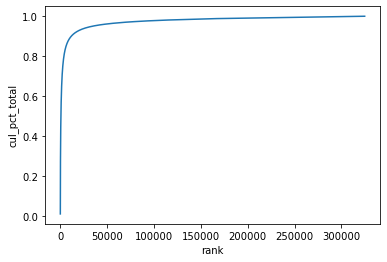

In [10]:
import seaborn as sns

# Cumulative Distribution Plot
sns.lineplot(x='rank', y='cul_pct_total', data=wc);

In [11]:
wc[wc['rank'] <= 5000]['cul_pct_total'].max()

0.8304546840851244

In [12]:
wc[wc['rank'] < 100.0]

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
81,patient,34477,130311,1.0,0.009698,0.009698,0.340027
233,virus,33167,103976,2.0,0.007738,0.017436,0.327107
342,study,45777,85586,3.0,0.006370,0.023806,0.451472
58,infection,32550,79913,4.0,0.005947,0.029753,0.321022
117,disease,33958,71169,5.0,0.005297,0.035050,0.334908
85,result,46842,65336,6.0,0.004863,0.039913,0.461975
228,cell,20119,62331,7.0,0.004639,0.044552,0.198422
70,respiratory,22623,53152,8.0,0.003956,0.048507,0.223118
66479,covid-19,14869,52480,9.0,0.003906,0.052413,0.146644
150,protein,16279,48226,10.0,0.003589,0.056002,0.160550


The most frequent words do appear in the query and filtering by `min_count` would help us train the model find similar words better.

So, none of the least frequent words appear in the query. 

### a) Initialize Word2Vec Model

In [13]:
model = gensim.models.Word2Vec(
    size=300, 
    window=5,
    min_count=20,
    negative=5,
    sample=1e-5,
    workers=cores-1
)

### b) Build vocab

In [14]:
%%time
model.build_vocab(docs, progress_per=10000)

2020-12-07 10:06:17,159 : INFO : collecting all words and their counts
2020-12-07 10:06:17,160 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-12-07 10:06:17,401 : INFO : PROGRESS: at sentence #10000, processed 1313392 words, keeping 76339 word types
2020-12-07 10:06:17,643 : INFO : PROGRESS: at sentence #20000, processed 2547918 words, keeping 129949 word types
2020-12-07 10:06:17,943 : INFO : PROGRESS: at sentence #30000, processed 4044652 words, keeping 163560 word types
2020-12-07 10:06:18,292 : INFO : PROGRESS: at sentence #40000, processed 5554786 words, keeping 191901 word types
2020-12-07 10:06:18,614 : INFO : PROGRESS: at sentence #50000, processed 6990961 words, keeping 219822 word types
2020-12-07 10:06:18,903 : INFO : PROGRESS: at sentence #60000, processed 8238920 words, keeping 238390 word types
2020-12-07 10:06:19,168 : INFO : PROGRESS: at sentence #70000, processed 9435693 words, keeping 253943 word types
2020-12-07 10:06:19,459 : INFO : 

CPU times: user 10.4 s, sys: 105 ms, total: 10.5 s
Wall time: 10.5 s


### c) Train model

In [15]:
%%time
model.train(docs, total_examples=model.corpus_count, epochs=10)

2020-12-07 10:06:27,629 : INFO : training model with 7 workers on 26760 vocabulary and 300 features, using sg=0 hs=0 sample=1e-05 negative=5 window=5
2020-12-07 10:06:28,649 : INFO : EPOCH 1 - PROGRESS: at 13.42% examples, 541209 words/s, in_qsize 12, out_qsize 1
2020-12-07 10:06:29,663 : INFO : EPOCH 1 - PROGRESS: at 25.96% examples, 562501 words/s, in_qsize 13, out_qsize 0
2020-12-07 10:06:30,664 : INFO : EPOCH 1 - PROGRESS: at 37.48% examples, 571089 words/s, in_qsize 13, out_qsize 0
2020-12-07 10:06:31,669 : INFO : EPOCH 1 - PROGRESS: at 49.93% examples, 570167 words/s, in_qsize 11, out_qsize 2
2020-12-07 10:06:32,678 : INFO : EPOCH 1 - PROGRESS: at 64.63% examples, 569620 words/s, in_qsize 13, out_qsize 0
2020-12-07 10:06:33,685 : INFO : EPOCH 1 - PROGRESS: at 78.89% examples, 563755 words/s, in_qsize 13, out_qsize 0
2020-12-07 10:06:34,692 : INFO : EPOCH 1 - PROGRESS: at 93.70% examples, 566371 words/s, in_qsize 13, out_qsize 0
2020-12-07 10:06:35,112 : INFO : worker thread finis

CPU times: user 4min 39s, sys: 4 s, total: 4min 43s
Wall time: 1min 14s


(42467287, 134366260)

### d) Save the model

In [16]:
# Store just the words + their trained embeddings.
model_save_path = "../data/embeddings/cbow_word2vec.bin"
model.wv.save(model_save_path)

2020-12-07 10:07:42,529 : INFO : saving Word2VecKeyedVectors object under ../data/embeddings/cbow_word2vec.bin, separately None
2020-12-07 10:07:42,531 : INFO : not storing attribute vectors_norm
2020-12-07 10:07:43,019 : INFO : saved ../data/embeddings/cbow_word2vec.bin


### e) Check Model performance

In [17]:
def load_queries(input_fpath: Path, dtype: str = 'csv', cols_to_keep=['topic-id', 'query', 'question'], index_col=['topic-id']) -> pd.DataFrame:
    """Loads queries file and returns it as pandas data frame
    """
    if dtype == 'csv':
        df = pd.read_csv(input_fpath, quotechar='"', index_col=index_col, usecols=cols_to_keep)
        # for each column
        for col in df.columns:
            # check if the columns contains string data
            if pd.api.types.is_string_dtype(df[col]):
                df[col] = df[col].str.strip() # removes front and end white spaces
                df[col] = df[col].str.replace('\s{2,}', ' ') # remove double or more white spaces
    return df

QUERY_FPATH = Path('../data/CORD-19/CORD-19/topics-rnd3.csv')
query_df = load_queries(QUERY_FPATH)
query_df.head()

,query,question
topic-id,,
1,coronavirus origin,what is the origin of COVID-19
2,coronavirus response to weather changes,how does the coronavirus respond to changes in...
3,coronavirus immunity,will SARS-CoV2 infected people develop immunit...
4,how do people die from the coronavirus,what causes death from Covid-19?
5,animal models of COVID-19,what drugs have been active against SARS-CoV o...


In [18]:
def most_similar(word: str, n=10):
    return model.wv.most_similar(positive=[word], topn=n)

In [20]:
most_similar('vaccine')

[('live-attenuated', 0.8699063062667847),
 ('immunogenicity', 0.8544971942901611),
 ('vectored', 0.8531398773193359),
 ('cross-protective', 0.8187982439994812),
 ('inactivated', 0.8166592121124268),
 ('cross-protection', 0.8087765574455261),
 ('vector-based', 0.7899948358535767),
 ('immunization', 0.7861459255218506),
 ('immunogenic', 0.7856000661849976),
 ('efficacious', 0.7807859182357788)]

In [21]:
most_similar('sars-cov-2')

[('sars-cov2', 0.8508985042572021),
 ('2019-ncov', 0.810357391834259),
 ('cov-2', 0.8068501949310303),
 ('coronavirus', 0.7973007559776306),
 ('2019-ncov.', 0.7959842681884766),
 ('coronavirus-2', 0.7932089567184448),
 ('sarscov2', 0.7900949716567993),
 ('disease-2019', 0.7891755700111389),
 ('sars-', 0.7825485467910767),
 ('2019-novel', 0.7792795300483704)]

In [19]:
most_similar('quarantine')

2020-12-07 10:07:43,053 : INFO : precomputing L2-norms of word weight vectors


[('distancing', 0.8528013229370117),
 ('strict', 0.8384310007095337),
 ('containment', 0.833786129951477),
 ('quarantining', 0.8291466236114502),
 ('quarantined', 0.8246265649795532),
 ('tracing', 0.8222387433052063),
 ('self-quarantine', 0.8033556938171387),
 ('lock-down', 0.7976255416870117),
 ('self-isolation', 0.7923141717910767),
 ('pre-symptomatic', 0.7876335382461548)]